WRF使用データ整形＆座標に対応したメッシュ農業気象データ（農研機構）取得
データ形式：netCDF
次元：（時刻、経度、緯度）
データ：
    amgsd...メッシュ農業気象データ
    amgsd_bc...メッシュ農業気象データ（バイキュービック補完）
    WRF_1km...低解像度WRFデータ
    WRF_1km_bc...低解像度WRFデータ（バイキュービック補完）
    WRF_300m...高解像度WRFデータ


備考
WRFの暖気運転に位置する12月30-31は削除
nanが存在する時刻を除去
2022-01-01T00:00:00.000000000


In [58]:
#データ関連
import numpy as np
import pandas as pd
import xarray as xr
import cv2
import utils.amd_tools4 as AMD
import math

#パス関連
from pathlib import Path
import os

#描画関連
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [59]:
#WRFoutの存在する場所の指定
root = "/mnt/nadaru/WRFdata"
AMDroot = "/mnt/nadaru/AMDdata"

In [ ]:
'''
データセット取得
場所：３領域（岩見沢駅、万字、栗山）から選択
抽出データ：2m相対湿度、気温、下向き長波放射量から選択

'''
#場所　iwamista or manji or kuriyama
loc = 'manji'
year = 2023

#抽出データ　RH2　or T2 or GLW
extdata = "T2"
path = os.path.join(root,f"{str(year)}/{loc}")


ds01 = xr.open_dataset(path + f"/wrfout_d01_{str(year-1)}-12-30_00:00:00")
ds02 = xr.open_dataset(path + f"/wrfout_d02_{str(year-1)}-12-30_00:00:00")


In [ ]:
'''
WRF出力結果から相対湿度の計算
'''
def calcRH2(dataset):
    dims = ('t', 'x', 'y')
    coords = {'latitude': (('x', 'y'), dataset["XLAT"][0].values),
              'longitude': (('x', 'y'), dataset["XLONG"][0].values),
              't': dataset['XTIME'].values,
              }
    T2 = dataset.variables['T2'][:]  # 2m気温 (K)
    Q2 = dataset.variables['Q2'][:]  # 2m比湿 (kg/kg)
    PSFC = dataset.variables['PSFC'][:]  # 地表気圧 (Pa)
    
    # 飽和水蒸気圧の計算
    es = 6.112 * np.exp((17.67 * (T2 - 273.15)) / (T2 - 29.65))  # hPaに単位換算
    
    # 実際の水蒸気圧の計算
    e = (Q2 * PSFC) / (0.622 + 0.378 * Q2) / 100  # PaをhPaに変換
    
    # 相対湿度の計算
    RH2 = (e / es) * 100  # %
    RH2_clipped = np.clip(RH2, 0, 100)
    dataarray   = xr.DataArray(RH2_clipped,coords, dims)

    return dataarray

dims = ('t', 'x', 'y')
coords = {'latitude': (('x', 'y'), ds01["XLAT"][0].values),
          'longitude': (('x', 'y'), ds01["XLONG"][0].values),
          't': ds01['XTIME'].values,
          }

coords2 = {'latitude': (('x', 'y'), ds02["XLAT"][0].values),
          'longitude': (('x', 'y'), ds02["XLONG"][0].values),
          't': ds01['XTIME'].values,
          }

if extdata == 'RH2':
    ds01 = calcRH2(ds01)
    ds02 = calcRH2(ds02)
else:
    ds01 = xr.DataArray(ds01[extdata][:],coords, dims)
    ds02 = xr.DataArray(ds02[extdata][:],coords2, dims)


In [ ]:
'''
メッシュ農業気象データ取得API（転載不可なため未掲載）による指定領域の気象データ取得。
'''

enddate = ds01["t"][-1].values
startdate = ds01["t"][0].values
ts = [pd.to_datetime(str(startdate)) ,pd.to_datetime(str(enddate))]
timedomain = [ts[0].strftime('%Y-%m-%dT%H'),ts[1].strftime('%Y-%m-%dT%H')]
lat = [ds01["latitude"].values.min(),ds01["latitude"].values.max()]
lon = [ds01["longitude"].values.min(),ds01["longitude"].values.max()]
lalodomain = lat+lon

if extdata == 'RH2':
    amdvar = 'RH'
elif extdata == 'GLW':
    amdvar = 'DLR'
elif extdata == 'T2':
    amdvar = 'TMP'



Tm, tim, lat, lon = AMD.GetMetDataHourly(amdvar, timedomain, lalodomain)
Tm_resize = np.array([cv2.resize(a, (51,51),interpolation=cv2.INTER_NEAREST) for a in Tm])

if extdata == "T2":
    Tm_resize += 273

TMP (8810, 57, 52) Hourly


'''
WRF1kmとの緯度経度誤差確認
結果：1km＝１ピクセルの誤差は生じる恐れあり
'''

# Haversine公式を使った球面距離計算
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # 地球の半径 (km)
    if lat1 - lat2 > 0:
        print('+')
    else:
        print('-')

    if lon1 - lon2 > 0:
        print('+')
    else:
        print('-')
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2) ** 2 + \
        math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c
    
laloamd = np.array([lat.min(),lat.max(),lon.min(),lon.max()])
lalowrf = np.array(lalodomain)

dist_dl = haversine(laloamd[0],laloamd[2],lalowrf[0],lalowrf[2])
print(dist_dl)
dist_ul = haversine(laloamd[1],laloamd[2],lalowrf[1],lalowrf[2])
print(dist_ul)
dist_dr = haversine(laloamd[0],laloamd[3],lalowrf[0],lalowrf[3])
print(dist_dr)
dist_ur = haversine(laloamd[1],laloamd[3],lalowrf[1],lalowrf[3])
print(dist_ur)

In [79]:
'''
xrデータアレイ作成
'''

dims = ('t', 'x', 'y')
coords = {'latitude': (('x', 'y'), ds01["latitude"].values),
          'longitude': (('x', 'y'), ds01["longitude"].values),
          't': tim[48:],
          }

coords2 = {'latitude': (('x', 'y'), ds02["latitude"].values),
          'longitude': (('x', 'y'), ds02["longitude"].values),
          't': tim[48:],
          }

amgsd = xr.DataArray(Tm_resize[48:],coords, dims)
d01_WRF   = xr.DataArray(ds01[48:],coords, dims)
d02_WRF   = xr.DataArray(ds02[48:],coords2, dims)


In [ ]:
'''
WRF_300mに合わせた切り出しを行う
'''

lat = [ds02["latitude"].values.min(),ds02["latitude"].values.max()]
lon = [ds02["longitude"].values.min(),ds02["longitude"].values.max()]
cond_lat = (lat[0] < amgsd.latitude) & (lat[1] > amgsd.latitude)
cond_lon = (lon[0] < amgsd.longitude) & (lon[1] > amgsd.longitude)

amgsd = amgsd.where(cond_lat & cond_lon , drop=True)
d01_WRF = d01_WRF.where(cond_lat & cond_lon , drop=True)

In [ ]:
'''
saizu
'''

amgsd_resize = np.array([cv2.resize(a, (51,51),interpolation=cv2.INTER_NEAREST) for a in amgsd.values])
wrf_resize = np.array([cv2.resize(a, (51,51),interpolation=cv2.INTER_NEAREST) for a in d01_WRF.values])

amgsd_resize_bc = np.array([cv2.resize(a, (51,51),interpolation=cv2.INTER_CUBIC) for a in amgsd.values])
wrf_resize_bc = np.array([cv2.resize(a, (51,51),interpolation=cv2.INTER_CUBIC) for a in d01_WRF.values])

amgsd = xr.DataArray(amgsd_resize,coords, dims)
amgsd_bc = xr.DataArray(amgsd_resize_bc,coords, dims)
wrf_lr = xr.DataArray(wrf_resize,coords, dims)
wrf_hr = d02_WRF
wrf_lr_bc = xr.DataArray(wrf_resize_bc,coords, dims)

In [ ]:
#欠損値の確認
c = 0
for a in range(8761):
    if np.isnan(amgsd[a].values).sum() != 0:
        c+=1
        print(amgsd.t[a].values)
        
print(c)

2023-01-01T00:00:00.000000000
1


In [ ]:
'''
データセット作成
'''

dsarray = xr.Dataset()
dsarray['amgsd'] = amgsd
dsarray['amgsd_bc'] = amgsd_bc
dsarray['WRF_1km'] = wrf_lr
dsarray['WRF_1km_bc'] = wrf_lr_bc
dsarray['WRF_300m'] = wrf_hr

271.40347
274.31177
274.31854


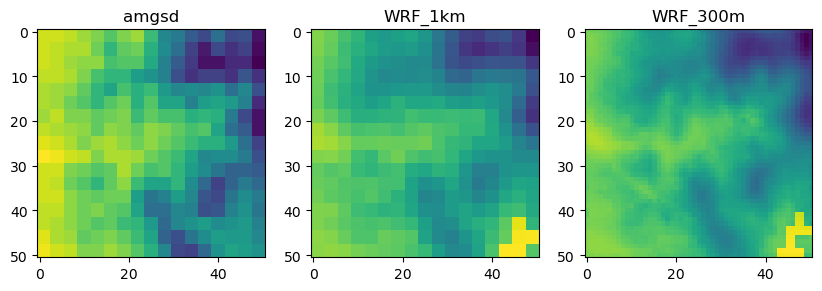

In [ ]:
#データ整合性チェック

fig = plt.figure(figsize=(10,30))
i = 2000
content= ['amgsd','WRF_1km','WRF_300m']
for a in range(3):
    sample = dsarray[content[a]][i,:,:]
    print(sample.mean().values)
    ax = fig.add_subplot(1,3,a+1)
    ax.imshow(dsarray[content[a]][i,:,:])
    ax.set_title(content[a])
plt.show()

In [85]:
#nan除去
dataset = dsarray.isel(t=slice(1,8761))

In [ ]:
'''
データセットの保存（netCDF）
'''

savepath = "/mnt/nadaru/trainingdataset/"
name = f'{amdvar}_{str(year)}_{loc}.nc'
dataset.to_netcdf(savepath+name)